# Árvore de Decisão (defaults)

In [ ]:
# -*- coding: utf-8 -*-
# ============================================================
# Classificação de Disciplina com Árvore de Decisão (defaults)
# ============================================================

import re
import json
import unicodedata
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Dict

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ----------------------------
# 1) CONFIGURAÇÕES BÁSICAS
# ----------------------------
EXCEL_PATH = Path("questoes discursivas.xlsx")
KEYWORDS_JSON_PATH = Path("keywords_by_class.json")

TEXT_COL = "texto"         # texto bruto (com LaTeX)
LABEL_COL = "Disciplina1"  # rótulo correto

# stopwords específicas fornecidas
STOPWORDS_CUSTOM = {
    'questao','questões','enunciado','considere','assinale','alternativa','alternativas','seguinte',
    'texto','figura','imagem','dados','valor','valores','item','itens','responda','marque',
    'de','da','do','das','dos','abaixo','acima','seguintes','correto','correta','corretos','corretas',
    'incorreto','incorreta','lacuna','lacunas','trecho','excerto','questoes'
}

In [ ]:
# -----------------------------------------
# 2) LIMPEZA DE LaTeX -> texto “legível”
# -----------------------------------------
_LATEX_CMD_RE = re.compile(r'\\[a-zA-Z@]+(\s*\[[^\]]*\])?(\s*\{[^{}]*\})?')
_ENV_BEGIN_RE = re.compile(r'\\begin\{.*?\}')
_ENV_END_RE   = re.compile(r'\\end\{.*?\}')
_MATH_INLINE  = re.compile(r'(\$\$.*?\$\$|\$.*?\$|\\\(|\\\)|\\\[|\\\])', re.DOTALL)
_COMMENT_RE   = re.compile(r'(?m)^%.*$')  # linhas que começam com %
_BRACES_RE    = re.compile(r'[\{\}]')
_MULTIWS_RE   = re.compile(r'\s+')

def strip_accents(s: str) -> str:
    return ''.join(ch for ch in unicodedata.normalize('NFKD', s) if not unicodedata.combining(ch))

def clean_latex_to_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    t = s

    # remove comentários LaTeX
    t = _COMMENT_RE.sub(' ', t)

    # remove ambientes \begin{...}...\end{...}
    t = _ENV_BEGIN_RE.sub(' ', t)
    t = _ENV_END_RE.sub(' ', t)

    # remove matemática ($...$, $$...$$, \( \), \[ \])
    t = _MATH_INLINE.sub(' ', t)

    # remove comandos \comando[...]{...} mantendo, quando possível, o conteúdo das chaves simples
    # estratégia: primeiro extrair conteúdos simples {texto} antes de remover tudo
    # mas como comandos e ambientes já saíram acima, aqui simplificamos removendo comandos restantes
    t = _LATEX_CMD_RE.sub(' ', t)

    # remove chaves “soltas”
    t = _BRACES_RE.sub(' ', t)

    # normaliza espaços
    t = _MULTIWS_RE.sub(' ', t).strip()

    # lowercase + remover acentos para matching estável
    t = strip_accents(t.lower())
    return t


In [ ]:
class StopwordStripper(BaseEstimator, TransformerMixin):
    def __init__(self, stopwords: set):
        # armazenar com o MESMO nome do parâmetro p/ sklearn
        self.stopwords = stopwords
        # criar versão normalizada para uso interno
        self.stop = {strip_accents(w.lower()) for w in stopwords}

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        cleaned = []
        for txt in X:
            tokens = [w for w in re.findall(r'\b\w+\b', txt) if w not in self.stop]
            cleaned.append(' '.join(tokens))
        return np.array(cleaned, dtype=object)


In [ ]:
# -----------------------------------------------------------------
# 4) TRANSFORMER: contagem de palavras-chave por disciplina
#     -> gera n_features = nº de disciplinas do JSON
# -----------------------------------------------------------------
class KeywordCountTransformer(BaseEstimator, TransformerMixin):
    """
    Gera um vetor de tamanho = nº de disciplinas com a contagem de ocorrências
    das palavras-chave de cada disciplina no texto de entrada.

    Aceita keywords_by_disciplina OU keywords_by_class (alias).
    Compatível com clone/get_params do sklearn.
    """
    def __init__(self, keywords_by_disciplina=None, keywords_by_class=None, lower=True, strip_acc=True):
        # >>> IMPORTANTE: atribuir os parâmetros a atributos de mesmo nome
        self.keywords_by_disciplina = keywords_by_disciplina
        self.keywords_by_class = keywords_by_class
        self.lower = lower
        self.strip_acc = strip_acc
        # atributos “aprendidos” no fit (sufixo _)
        self.disciplinas_ = None
        self.patterns_ = None

    def _norm(self, s: str) -> str:
        if not isinstance(s, str):
            s = "" if s is None else str(s)
        if self.lower:
            s = s.lower()
        if self.strip_acc:
            s = strip_accents(s)
        return s

    def _get_map(self) -> Dict[str, List[str]]:
        mapping = self.keywords_by_disciplina if self.keywords_by_disciplina is not None else self.keywords_by_class
        return mapping or {}

    def fit(self, X, y=None):
        mapping = self._get_map()
        self.disciplinas_ = list(mapping.keys())
        self.patterns_ = []
        for _, kws in mapping.items():
            norm_kws = []
            for k in kws or []:
                if not isinstance(k, str):
                    continue
                kk = self._norm(k).strip()
                if kk:
                    norm_kws.append(re.escape(kk))
            pat = re.compile(r'(' + '|'.join(norm_kws) + r')') if norm_kws else None
            self.patterns_.append(pat)
        return self

    def transform(self, X):
        # aceitar Series, lista, array 1D/2D
        if isinstance(X, np.ndarray) and X.ndim == 2 and X.shape[1] == 1:
            X = X.ravel()
        feats = np.zeros((len(X), len(self.disciplinas_)), dtype=float)
        for i, txt in enumerate(X):
            s = self._norm(txt)
            for j, pat in enumerate(self.patterns_):
                feats[i, j] = len(pat.findall(s)) if pat else 0.0
        return feats

In [ ]:
# ---------------------------------------------------
# 5) CARREGAR DADOS E KEYWORDS
# ---------------------------------------------------
df = pd.read_excel(EXCEL_PATH)

# garante colunas esperadas
expected_cols = {"Question_id", "texto", "Assunto", "Id Assunto", "Disciplina1"}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"Colunas ausentes em {EXCEL_PATH}: {missing}")

with open(KEYWORDS_JSON_PATH, "r", encoding="utf-8") as f:
    keywords_map = json.load(f)

X_raw = df[TEXT_COL].fillna("")
y = df[LABEL_COL].astype(str).fillna("")

# Remover rótulos "0" (string ou numérico convertido)
df[LABEL_COL] = df[LABEL_COL].astype(str).str.strip()
df = df[df[LABEL_COL] != "0"].copy()

X_raw = df[TEXT_COL].fillna("")
y = df[LABEL_COL].astype(str)
print("Distribuição pós-remoção de '0':")
print(y.value_counts().sort_index())


Distribuição pós-remoção de '0':
Disciplina1
Arte                   10
Biologia             1106
Filosofia             258
Física               1271
Geografia            1385
História             1761
Literatura            289
Língua Espanhola      317
Língua Inglesa        851
Língua Portuguesa    1514
Matemática           4429
Química              1538
Sociologia            120
Name: count, dtype: int64


In [ ]:

# ---------------------------------------------------
# 6) PIPELINE
# ---------------------------------------------------
# Passo A: limpar LaTeX + normalizar
latex_cleaner = FunctionTransformer(
    lambda s: np.array([clean_latex_to_text(t) for t in s], dtype=object),
    validate=False
)

# Passo B: remover stopwords personalizadas
stop_strip = StopwordStripper(STOPWORDS_CUSTOM)

# Para combinar TF-IDF com features de keywords, aplicaremos AMBOS sobre a MESMA coluna “text”
# Por isso, primeiro empacotamos a Serie em um DataFrame com coluna única
to_frame = FunctionTransformer(lambda s: pd.DataFrame({"text": s}), validate=False)

# Bloco de features
features = ColumnTransformer(
    transformers=[
        ("tfidf",
         TfidfVectorizer(
             ngram_range=(1, 2),
             min_df=2,
             max_df=0.9,
             sublinear_tf=True,
             norm="l2",
         ),
         "text"),
        ("kw_counts",
         KeywordCountTransformer(keywords_by_disciplina=keywords_map),  # ou keywords_by_class=keywords_map
         "text"),
    ],
    remainder="drop"
)


# Classificador: Decision Tree com hiperparâmetros default
clf = DecisionTreeClassifier()  # defaults

pipe = Pipeline(steps=[
    ("clean_latex", latex_cleaner),
    ("strip_stop", stop_strip),
    ("to_frame", to_frame),
    ("features", features),
    ("clf", clf)
])

Distribuição após filtrar por whitelist:
Disciplina1
Arte                   10
Biologia             1106
Filosofia             258
Física               1271
Geografia            1385
História             1761
Literatura            289
Língua Espanhola      317
Língua Inglesa        851
Língua Portuguesa    1514
Matemática           4429
Química              1538
Sociologia            120
Name: count, dtype: int64
Tamanho do treino após cap: 8361
Distribuição por classe (treino capped):
label
Arte                    8
Biologia              885
Filosofia             206
Física               1000
Geografia            1000
História             1000
Literatura            231
Língua Espanhola      254
Língua Inglesa        681
Língua Portuguesa    1000
Matemática           1000
Química              1000
Sociologia             96
Name: count, dtype: int64


/tmp/ipython-input-3780571574.py:47: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.




Accuracy (teste): 0.5714

                   precision    recall  f1-score   support

             Arte       0.00      0.00      0.00         2
         Biologia       0.41      0.48      0.44       221
        Filosofia       0.39      0.42      0.40        52
           Física       0.55      0.67      0.60       254
        Geografia       0.43      0.46      0.44       277
         História       0.53      0.52      0.53       352
       Literatura       0.25      0.29      0.27        58
 Língua Espanhola       0.59      0.63      0.61        63
   Língua Inglesa       0.51      0.56      0.54       170
Língua Portuguesa       0.49      0.51      0.50       303
       Matemática       0.83      0.68      0.75       886
          Química       0.57      0.56      0.57       308
       Sociologia       0.04      0.04      0.04        24

         accuracy                           0.57      2970
        macro avg       0.43      0.45      0.44      2970
     weighted avg       0.5

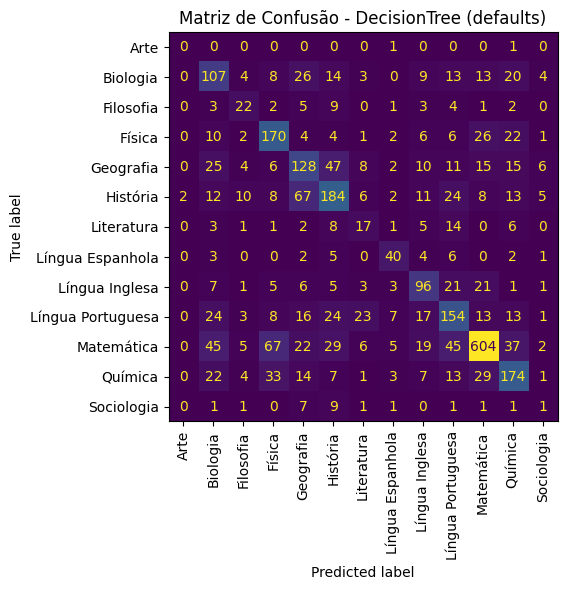

In [ ]:
# ---------------------------------------------------
# 7) TREINO / AVALIAÇÃO
# ---------------------------------------------------
from sklearn.model_selection import train_test_split

MAX_PER_CLASS_TRAIN = 1000
TEST_SIZE = 0.2
RANDOM_STATE = 42

VALID_CLASSES = {"Arte","Biologia","Filosofia","Física","Geografia","História","Língua Espanhola","Língua Inglesa",
                 "Língua Portuguesa","Literatura","Matemática","Química","Sociologia"

                }

df[LABEL_COL] = df[LABEL_COL].astype(str).str.strip()

mask_valid = df[LABEL_COL].isin(VALID_CLASSES)
if (~mask_valid).any():
    print("Removendo rótulos inválidos/encontrados fora da whitelist:")
    print(df.loc[~mask_valid, LABEL_COL].value_counts())

df = df.loc[mask_valid].copy()

X_raw = df[TEXT_COL].fillna("")
y = df[LABEL_COL]
print("Distribuição após filtrar por whitelist:")
print(y.value_counts().sort_index())


# Split estratificado
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

# Constrói DataFrame para facilitar o "cap" por classe no TREINO
df_train = pd.DataFrame({
    "text": X_train_raw.values,
    "label": y_train.values
})

# Função utilitária: limita amostras por classe (apenas no treino)
def cap_per_class(df_in, label_col, max_per_class, random_state=RANDOM_STATE):
    # Para cada classe, amostra até max_per_class (se tiver menos, mantém todas)
    capped = (
        df_in
        .groupby(label_col, group_keys=False)
        .apply(lambda g: g.sample(n=min(len(g), max_per_class),
                                  random_state=random_state))
        .reset_index(drop=True)
    )
    return capped

df_train_capped = cap_per_class(df_train, "label", MAX_PER_CLASS_TRAIN, RANDOM_STATE)

# Recupera X/y após o cap
X_train = df_train_capped["text"].values
y_train = df_train_capped["label"].values

# (opcional) Diagnóstico rápido do balanceamento aplicado
print("Tamanho do treino após cap:", len(df_train_capped))
print("Distribuição por classe (treino capped):")
print(df_train_capped["label"].value_counts().sort_index())

# AJUSTE/AVALIAÇÃO COM O PIPELINE EXISTENTE
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test_raw)

from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy (teste): {acc:.4f}\n")
print(classification_report(y_test, y_pred, zero_division=0))

fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, xticks_rotation=90, colorbar=False)
ax.set_title("Matriz de Confusão - DecisionTree (defaults)")
plt.tight_layout()
plt.show()

#import seaborn as sns
#sns.heatmap(y_train.cov(), annot=True, cmap='YlGnBu')


# PCA

In [ ]:
# =============================================
# PCA 3D — Usando o CONJUNTO DE TREINO
# =============================================
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

print("🔎 Extraindo embeddings do pipeline...")

# usamos X_train (textos limpos usados no fit)
X_source = pd.Series(X_train)

# pipeline até o step de features
cleaned = pipe.named_steps["clean_latex"].transform(X_source)
stripped = pipe.named_steps["strip_stop"].transform(cleaned)
framed  = pipe.named_steps["to_frame"].transform(stripped)

X_all = pipe.named_steps["features"].transform(framed)

try:
    X_dense = X_all.toarray()
    print("✅ Vetores convertidos para denso.")
except Exception:
    X_dense = X_all
    print("⚠️ Mantendo formato esparso.")

print("🎛️ Rodando PCA...")
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_dense)

df_emb = pd.DataFrame({
    "pca3d_x": X_pca[:, 0],
    "pca3d_y": X_pca[:, 1],
    "pca3d_z": X_pca[:, 2],
    LABEL_COL: y_train,            # rótulos do treino
    "texto_preview": X_source.str.slice(0, 200)
})

# Amostra p/ visualizar
MAX_PTS = 15000
df_plot = df_emb.sample(MAX_PTS, random_state=42) if len(df_emb) > MAX_PTS else df_emb

import plotly.express as px
fig = px.scatter_3d(
    df_plot,
    x="pca3d_x", y="pca3d_y", z="pca3d_z",
    color=LABEL_COL,
    opacity=0.75,
    hover_data={"texto_preview": True, LABEL_COL: True},
    title="PCA 3D — Espaço de treino por disciplina"
)

fig.update_traces(marker=dict(size=3))
fig.update_layout(template="plotly_white")
fig.show()

fig.write_html("pca3d_treino.html", include_plotlyjs="cdn")
print("✅ PCA salvo em pca3d_treino.html")


🔎 Extraindo embeddings do pipeline...
✅ Vetores convertidos para denso.
🎛️ Rodando PCA...


✅ PCA salvo em pca3d_treino.html


In [ ]:
# ---------------------------------------------------
# 8) USO EM PRODUÇÃO: predict em novas questões
# ---------------------------------------------------
# Exemplo:
novas_questoes = pd.Series([
#     r"Considere o circuito elétrico a seguir. Calcule a potência dissipada no resistor R..."
     r"""
     O governo de Eurico Gaspar Dutra (1946-1951) marcou a transição do Brasil de um período autoritário para um regime democrático. Durante o seu mandato, o país experimentou mudanças significativas tanto no campo político quanto econômico. Dutra enfrentou o desafio de reconstruir as instituições democráticas após o Estado Novo e adotou uma política econômica influenciada pelo contexto internacional da Guerra Fria.

Com base nessas informações, assinale a alternativa que melhor caracteriza uma das principais ações políticas do governo Dutra

     """
])
pred = pipe.predict(novas_questoes)
print(pred)


['História']


#SVM

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




Accuracy (teste) - SVM: 0.8626

                   precision    recall  f1-score   support

             Arte       0.00      0.00      0.00         2
         Biologia       0.85      0.88      0.86       221
        Filosofia       0.88      0.71      0.79        52
           Física       0.80      0.89      0.84       254
        Geografia       0.75      0.84      0.79       277
         História       0.83      0.86      0.84       352
       Literatura       0.60      0.55      0.58        58
 Língua Espanhola       0.89      0.79      0.84        63
   Língua Inglesa       0.85      0.72      0.78       170
Língua Portuguesa       0.83      0.86      0.84       303
       Matemática       0.95      0.93      0.94       886
          Química       0.92      0.90      0.91       308
       Sociologia       1.00      0.17      0.29        24

         accuracy                           0.86      2970
        macro avg       0.78      0.70      0.72      2970
     weighted avg    

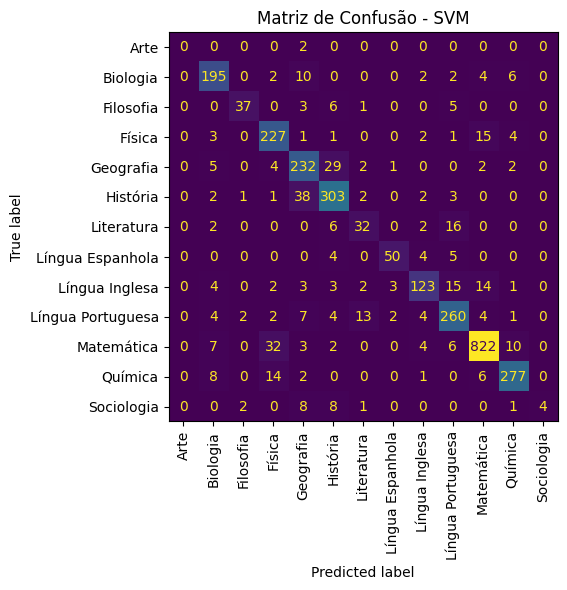

In [ ]:
# ============================================================
# Classificação de Disciplina com SVM (SVC)
# ============================================================

from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

# Criar novo pipeline copiando o anterior, mas trocando o classificador
pipe_svm = Pipeline(steps=[
    ("clean_latex", latex_cleaner),
    ("strip_stop", stop_strip),
    ("to_frame", to_frame),
    ("features", features),
    ("clf", LinearSVC(random_state=RANDOM_STATE))
])

# Treinar o modelo SVM
pipe_svm.fit(X_train, y_train)

# Predizer no conjunto de teste
y_pred_svm = pipe_svm.predict(X_test_raw)

# Calcular acurácia
acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"\nAccuracy (teste) - SVM: {acc_svm:.4f}\n")

# Relatório de classificação
print(classification_report(y_test, y_pred_svm, zero_division=0))

# Matriz de confusão
fig, ax = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, ax=ax, xticks_rotation=90, colorbar=False)
ax.set_title("Matriz de Confusão - SVM")
plt.tight_layout()
plt.show()


# GridSearch - Linear SVM

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Melhores parâmetros:
{'clf__C': 1, 'clf__loss': 'squared_hinge'}

Accuracy (teste) - SVM (GridSearch): 0.8626

Relatório de Classificação:
                   precision    recall  f1-score   support

             Arte       0.00      0.00      0.00         2
         Biologia       0.85      0.88      0.86       221
        Filosofia       0.88      0.71      0.79        52
           Física       0.80      0.89      0.84       254
        Geografia       0.75      0.84      0.79       277
         História       0.83      0.86      0.84       352
       Literatura       0.60      0.55      0.58        58
 Língua Espanhola       0.89      0.79      0.84        63
   Língua Inglesa       0.85      0.72      0.78       170
Língua Portuguesa       0.83      0.86      0.84       303
       Matemática       0.95      0.93      0.94       886
          Química       0.92      0.90      0.91       308
       Sociologia       1.00   

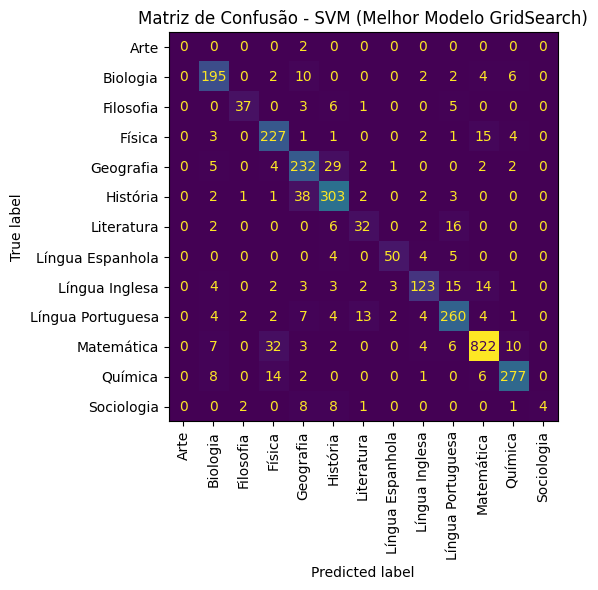

In [ ]:
# ============================================================
# Grid Search para SVM (LinearSVC)
# ============================================================
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Novo pipeline trocando o classificador para LinearSVC (igual ao anterior)
pipe_svm = Pipeline(steps=[
    ("clean_latex", latex_cleaner),
    ("strip_stop", stop_strip),
    ("to_frame", to_frame),
    ("features", features),
    ("clf", LinearSVC(max_iter=5000, random_state=RANDOM_STATE))
])

# Espaço de busca — parâmetros mais relevantes para textos
param_grid = {
    "clf__C": [0.01, 0.1, 1, 5, 10],
    "clf__loss": ["hinge", "squared_hinge"]
}

grid = GridSearchCV(
    estimator=pipe_svm,
    param_grid=param_grid,
    n_jobs=-1,
    cv=3,
    scoring="accuracy",
    verbose=2
)

grid.fit(X_train, y_train)

print("\n=======================")
print("Melhores parâmetros:")
print(grid.best_params_)
print("=======================")

# Predição com o melhor modelo
best_model = grid.best_estimator_
y_pred_svm = best_model.predict(X_test_raw)

# Métricas
acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"\nAccuracy (teste) - SVM (GridSearch): {acc_svm:.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_svm, zero_division=0))

# Matriz de confusão
fig, ax = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, ax=ax, xticks_rotation=90, colorbar=False)
ax.set_title("Matriz de Confusão - SVM (Melhor Modelo GridSearch)")
plt.tight_layout()
plt.show()


# Naive Bayes + GridSearch + Validação

🔄 Treinando Naive Bayes com GridSearchCV...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

✅ Melhores parâmetros encontrados:
{'clf__alpha': 0.01, 'clf__fit_prior': True}

🎯 Accuracy no teste (Naive Bayes): 0.8357

                   precision    recall  f1-score   support

             Arte       0.00      0.00      0.00         2
         Biologia       0.83      0.86      0.85       221
        Filosofia       0.76      0.71      0.73        52
           Física       0.70      0.89      0.79       254
        Geografia       0.76      0.86      0.81       277
         História       0.82      0.87      0.84       352
       Literatura       0.55      0.66      0.60        58
 Língua Espanhola       0.84      0.76      0.80        63
   Língua Inglesa       0.89      0.58      0.70       170
Língua Portuguesa       0.76      0.89      0.82       303
       Matemática       0.97      0.85      0.90       886
          Química       0.88      0.89      0.89       308
  

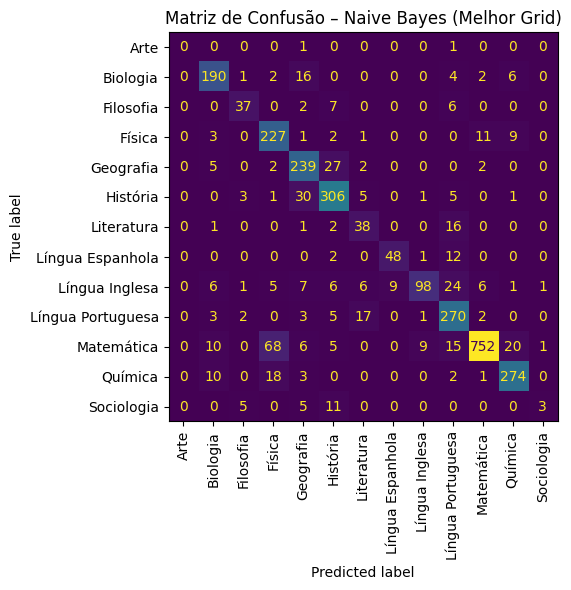

In [ ]:
# ============================================================
# Multinomial Naive Bayes com GridSearch + Validação
# ============================================================
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Pipeline: mesmo pré-processamento, novo classificador
pipe_nb = Pipeline(steps=[
    ("clean_latex", latex_cleaner),
    ("strip_stop", stop_strip),
    ("to_frame", to_frame),
    ("features", features),
    ("clf", MultinomialNB())
])

# Espaço de busca (NB usa alfa para suavização)
param_grid_nb = {
    "clf__alpha": [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0],
    "clf__fit_prior": [True, False]
}

grid_nb = GridSearchCV(
    estimator=pipe_nb,
    param_grid=param_grid_nb,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=2
)

print("🔄 Treinando Naive Bayes com GridSearchCV...")
grid_nb.fit(X_train, y_train)

print("\n✅ Melhores parâmetros encontrados:")
print(grid_nb.best_params_)

# Melhor modelo
best_nb = grid_nb.best_estimator_
y_pred_nb = best_nb.predict(X_test_raw)

# Acurácia
acc_nb = accuracy_score(y_test, y_pred_nb)
print(f"\n🎯 Accuracy no teste (Naive Bayes): {acc_nb:.4f}\n")

# Relatório de classificação
print(classification_report(y_test, y_pred_nb, zero_division=0))

# Matriz de confusão
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb, ax=ax, xticks_rotation=90, colorbar=False)
ax.set_title("Matriz de Confusão – Naive Bayes (Melhor Grid)")
plt.tight_layout()
plt.show()


# Random Forest

🌲 Treinando Random Forest...

🎯 Accuracy no teste — Random Forest (sem GridSearch): 0.7848

                   precision    recall  f1-score   support

             Arte       0.00      0.00      0.00         2
         Biologia       0.68      0.69      0.69       221
        Filosofia       1.00      0.38      0.56        52
           Física       0.77      0.83      0.80       254
        Geografia       0.69      0.71      0.70       277
         História       0.71      0.80      0.75       352
       Literatura       0.70      0.24      0.36        58
 Língua Espanhola       0.98      0.75      0.85        63
   Língua Inglesa       0.81      0.59      0.68       170
Língua Portuguesa       0.68      0.84      0.75       303
       Matemática       0.89      0.90      0.90       886
          Química       0.85      0.81      0.83       308
       Sociologia       0.00      0.00      0.00        24

         accuracy                           0.78      2970
        macro avg    

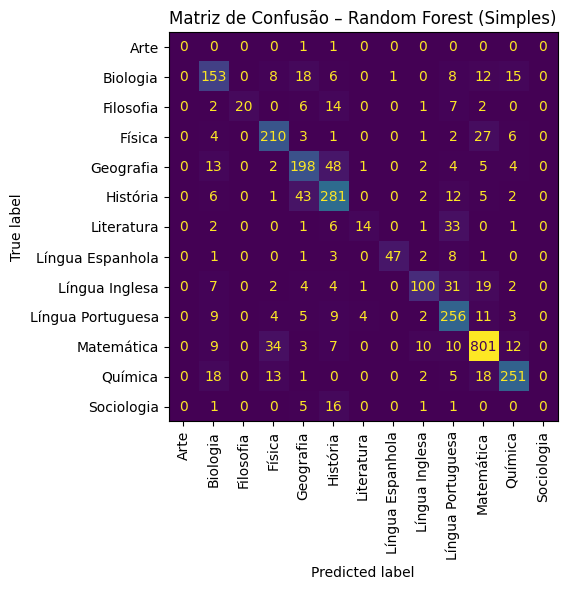

In [ ]:
# ============================================================
# Random Forest (sem GridSearch)
# ============================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Pipeline: mesmo pré-processamento + Random Forest
pipe_rf_simple = Pipeline(steps=[
    ("clean_latex", latex_cleaner),
    ("strip_stop", stop_strip),
    ("to_frame", to_frame),
    ("features", features),
    ("clf", RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

print("🌲 Treinando Random Forest...")
pipe_rf_simple.fit(X_train, y_train)

# Predição
y_pred_rf_simple = pipe_rf_simple.predict(X_test_raw)

# Métricas
acc_rf_simple = accuracy_score(y_test, y_pred_rf_simple)
print(f"\n🎯 Accuracy no teste — Random Forest (sem GridSearch): {acc_rf_simple:.4f}\n")

print(classification_report(y_test, y_pred_rf_simple, zero_division=0))

# Matriz de confusão
fig, ax = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_simple, ax=ax, xticks_rotation=90, colorbar=False)
ax.set_title("Matriz de Confusão – Random Forest (Simples)")
plt.tight_layout()
plt.show()


# Logistic Regression (sem gridserach)

⚙️ Treinando Logistic Regression...

🎯 Accuracy no teste — Logistic Regression (sem GridSearch): 0.8030

                   precision    recall  f1-score   support

             Arte       0.00      0.00      0.00         2
         Biologia       0.72      0.77      0.75       221
        Filosofia       0.72      0.60      0.65        52
           Física       0.75      0.83      0.79       254
        Geografia       0.70      0.75      0.73       277
         História       0.77      0.78      0.77       352
       Literatura       0.50      0.36      0.42        58
 Língua Espanhola       0.95      0.63      0.76        63
   Língua Inglesa       0.84      0.69      0.76       170
Língua Portuguesa       0.74      0.85      0.79       303
       Matemática       0.89      0.90      0.89       886
          Química       0.89      0.84      0.87       308
       Sociologia       0.00      0.00      0.00        24

         accuracy                           0.80      2970
        

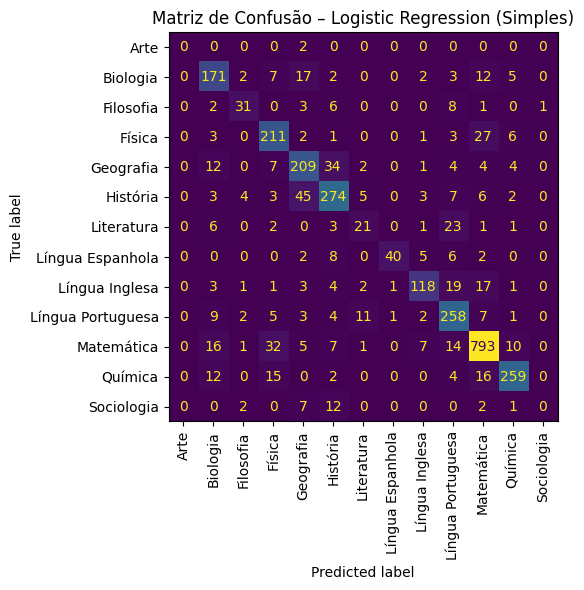

In [ ]:
# ============================================================
# Logistic Regression (sem GridSearch)
# ============================================================
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Pipeline completo com Logistic Regression
pipe_lr_simple = Pipeline(steps=[
    ("clean_latex", latex_cleaner),
    ("strip_stop", stop_strip),
    ("to_frame", to_frame),
    ("features", features),
    ("clf", LogisticRegression(
        max_iter=5000,
        solver="saga",
        penalty="l2",
        C=1.0,                 # força da regularização (default)
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

print("⚙️ Treinando Logistic Regression...")
pipe_lr_simple.fit(X_train, y_train)

# Predição
y_pred_lr_simple = pipe_lr_simple.predict(X_test_raw)

# Métricas
acc_lr_simple = accuracy_score(y_test, y_pred_lr_simple)
print(f"\n🎯 Accuracy no teste — Logistic Regression (sem GridSearch): {acc_lr_simple:.4f}\n")

print(classification_report(y_test, y_pred_lr_simple, zero_division=0))

# Matriz de confusão
fig, ax = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr_simple, ax=ax, xticks_rotation=90, colorbar=False)
ax.set_title("Matriz de Confusão – Logistic Regression (Simples)")
plt.tight_layout()
plt.show()


🧾 Treinando modelo Bag-of-Words...

🎯 Accuracy Bag-of-Words: 0.8364

                   precision    recall  f1-score   support

             Arte       0.00      0.00      0.00         2
         Biologia       0.78      0.81      0.80       221
        Filosofia       0.93      0.52      0.67        52
           Física       0.79      0.85      0.82       254
        Geografia       0.76      0.81      0.78       277
         História       0.80      0.84      0.82       352
       Literatura       0.67      0.45      0.54        58
 Língua Espanhola       0.83      0.79      0.81        63
   Língua Inglesa       0.80      0.69      0.74       170
Língua Portuguesa       0.79      0.86      0.82       303
       Matemática       0.90      0.92      0.91       886
          Química       0.93      0.86      0.89       308
       Sociologia       1.00      0.25      0.40        24

         accuracy                           0.84      2970
        macro avg       0.77      0.67      

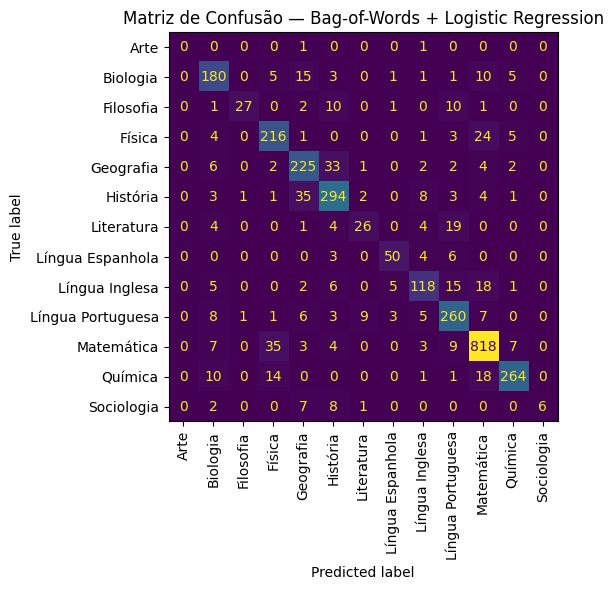

In [ ]:
# ============================================================
# Pipeline Bag-of-Words (simples, sem ColumnTransformer)
# ============================================================
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

pipe_bow = Pipeline(steps=[
    ("clean_latex", latex_cleaner),
    ("strip_stop", stop_strip),
    ("to_frame", FunctionTransformer(lambda s: s, validate=False)),  # NÃO virar DataFrame com coluna text
    ("bow", CountVectorizer(
        ngram_range=(1,2),
        min_df=1,
        max_df=1.0    # permitir todas as palavras
    )),
    ("clf", LogisticRegression(
        max_iter=5000,
        solver="saga",
        penalty="l2",
        C=1.0,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

print("🧾 Treinando modelo Bag-of-Words...")
pipe_bow.fit(X_train, y_train)
y_pred_bow = pipe_bow.predict(X_test_raw)

acc_bow = accuracy_score(y_test, y_pred_bow)
print(f"\n🎯 Accuracy Bag-of-Words: {acc_bow:.4f}\n")
print(classification_report(y_test, y_pred_bow, zero_division=0))

fig, ax = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_bow, ax=ax, xticks_rotation=90, colorbar=False)
ax.set_title("Matriz de Confusão — Bag-of-Words + Logistic Regression")
plt.tight_layout()
plt.show()


# Performance por algorítmo

In [ ]:
# ============================================================
# Tabela de Performance comparativa entre modelos (robusta)
# ============================================================
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

results = []

def collect_metrics(model_name, y_true, y_pred):
    return {
        "Modelo": model_name,
        "Accuracy": float(accuracy_score(y_true, y_pred)),
        "Precision (macro)": float(precision_score(y_true, y_pred, average="macro", zero_division=0)),
        "Recall (macro)": float(recall_score(y_true, y_pred, average="macro", zero_division=0)),
        "F1 Score (macro)": float(f1_score(y_true, y_pred, average="macro", zero_division=0)),
    }

# ✅ adicionar cada modelo já treinado
results.append(collect_metrics("Decision Tree", y_test, y_pred))
results.append(collect_metrics("Logistic Regression", y_test, y_pred_lr_simple))
results.append(collect_metrics("Naive Bayes", y_test, y_pred_nb))
results.append(collect_metrics("SVM (Linear)", y_test, y_pred_svm))
results.append(collect_metrics("Random Forest", y_test, y_pred_rf_simple))

# ✅ inserir o Bag-of-Words
results.append(collect_metrics("Bag-of-Words", y_test, y_pred_bow))

df_results = pd.DataFrame(results)

# Ordenar pelo F1 macro
df_results = df_results.sort_values(by="F1 Score (macro)", ascending=False).reset_index(drop=True)

# Formatar apenas colunas numéricas
numeric_cols = ["Accuracy", "Precision (macro)", "Recall (macro)", "F1 Score (macro)"]

display(
    df_results.style
    .format({col: "{:.4f}" for col in numeric_cols})
    .background_gradient(cmap="Blues")
)


,Modelo,Accuracy,Precision (macro),Recall (macro),F1 Score (macro)
0,SVM (Linear),0.8626,0.7810,0.7005,0.7160
1,Bag-of-Words,0.8364,0.7673,0.6659,0.6924
2,Naive Bayes,0.8357,0.7205,0.6881,0.6873
3,Logistic Regression,0.8030,0.6521,0.6163,0.6292
4,Random Forest,0.7848,0.6725,0.5813,0.6042
5,Decision Tree,0.5714,0.4297,0.4501,0.4382


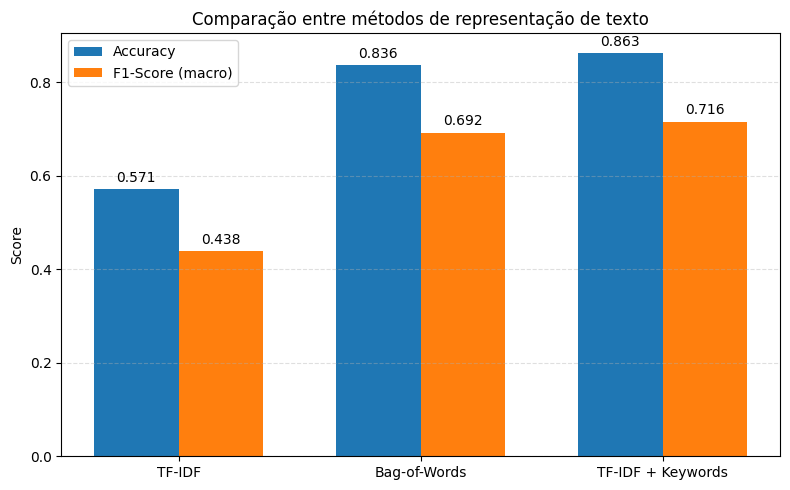

In [ ]:
# ============================================================
# Comparação gráfica — TFIDF vs Bag-of-Words vs TF-IDF+Keywords
# ============================================================
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Coletar métricas das 3 abordagens
results_inputs = {
    "TF-IDF": {
        "Accuracy": accuracy_score(y_test, y_pred),  # seu baseline TF-IDF
        "F1": f1_score(y_test, y_pred, average="macro", zero_division=0),
    },
    "Bag-of-Words": {
        "Accuracy": accuracy_score(y_test, y_pred_bow),
        "F1": f1_score(y_test, y_pred_bow, average="macro", zero_division=0),
    },
    "TF-IDF + Keywords": {
        "Accuracy": accuracy_score(y_test, y_pred_svm),  # SVM com TF-IDF+keywords ou seu melhor modelo
        "F1": f1_score(y_test, y_pred_svm, average="macro", zero_division=0),
    },
}

labels = list(results_inputs.keys())
accuracy_values = [results_inputs[m]["Accuracy"] for m in labels]
f1_values = [results_inputs[m]["F1"] for m in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, accuracy_values, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1_values, width, label='F1-Score (macro)')

ax.set_ylabel('Score')
ax.set_title('Comparação entre métodos de representação de texto')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.4)

# adicionar valores nas barras
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f"{height:.3f}",
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


# KNN

🔍 Treinando KNN...

🎯 Accuracy no teste — KNN: 0.5027

                   precision    recall  f1-score   support

             Arte       0.00      0.00      0.00         2
         Biologia       0.27      0.52      0.36       221
        Filosofia       0.53      0.33      0.40        52
           Física       0.36      0.72      0.48       254
        Geografia       0.51      0.33      0.40       277
         História       0.62      0.39      0.48       352
       Literatura       0.41      0.16      0.23        58
 Língua Espanhola       0.91      0.48      0.62        63
   Língua Inglesa       0.55      0.26      0.36       170
Língua Portuguesa       0.46      0.44      0.45       303
       Matemática       0.60      0.66      0.63       886
          Química       0.75      0.48      0.59       308
       Sociologia       0.00      0.00      0.00        24

         accuracy                           0.50      2970
        macro avg       0.46      0.37      0.38      2970

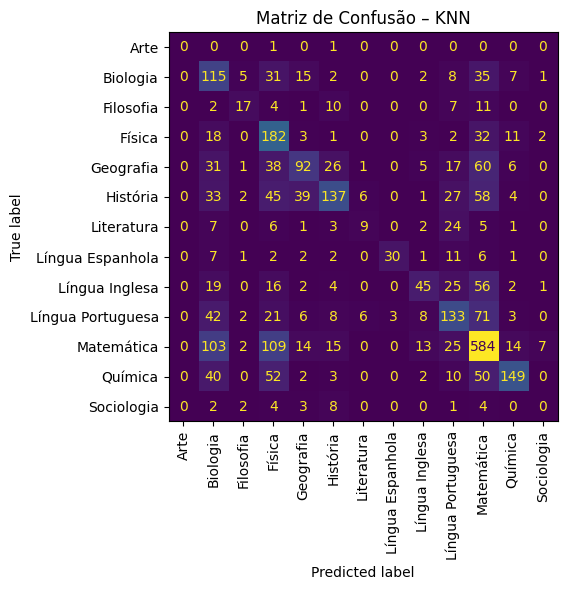

In [ ]:
"""# KNN"""

# ============================================================
# KNN (K-Nearest Neighbors)
# ============================================================
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Pipeline: mesmo pré-processamento + KNN
pipe_knn = Pipeline(steps=[
    ("clean_latex", latex_cleaner),
    ("strip_stop", stop_strip),
    ("to_frame", to_frame),
    ("features", features),
    ("clf", KNeighborsClassifier(
        n_neighbors=50,       # valor padrão, ajustável
        weights="distance",  # "distance" costuma funcionar melhor para texto que "uniform"
        metric="cosine",     # distância cosseno é muito boa para embeddings/texto
        n_jobs=-1
    ))
])

print("🔍 Treinando KNN...")
pipe_knn.fit(X_train, y_train)

# Predição
y_pred_knn = pipe_knn.predict(X_test_raw)

# Métricas
acc_knn = accuracy_score(y_test, y_pred_knn)
print(f"\n🎯 Accuracy no teste — KNN: {acc_knn:.4f}\n")

print(classification_report(y_test, y_pred_knn, zero_division=0))

# Matriz de confusão
fig, ax = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn, ax=ax, xticks_rotation=90, colorbar=False)
ax.set_title("Matriz de Confusão – KNN")
plt.tight_layout()
plt.show()


# Teste em massa de questões

In [ ]:
"""import pandas as pd

# Carrega a planilha
df = pd.read_excel("teste em massa.xlsx")

# Pega o texto da coluna latex
textos = df["latex"]

# Faz a predição
predicoes = pipe.predict(textos)

# Se o modelo retorna índices, lembre-se de mapear para os nomes das classes.
# Exemplo (ajuste para suas classes):
predicoes = pipe.predict(textos)

# O modelo já retorna strings
df["Previsao"] = predicoes


# Cria coluna Precisao (1 se acertou, 0 se errou)
df["Precisao"] = (df["Previsao"] == df["Disciplina1"]).astype(int)

# Salva resultado
df.to_excel("resultado_classificacao.xlsx", index=False)

print("✅ Processamento finalizado! Arquivo salvo como resultado_classificacao.xlsx") """


'import pandas as pd\n\n# Carrega a planilha\ndf = pd.read_excel("teste em massa.xlsx")\n\n# Pega o texto da coluna latex\ntextos = df["latex"]\n\n# Faz a predição\npredicoes = pipe.predict(textos)\n\n# Se o modelo retorna índices, lembre-se de mapear para os nomes das classes.\n# Exemplo (ajuste para suas classes):\npredicoes = pipe.predict(textos)\n\n# O modelo já retorna strings\ndf["Previsao"] = predicoes\n\n\n# Cria coluna Precisao (1 se acertou, 0 se errou)\ndf["Precisao"] = (df["Previsao"] == df["Disciplina1"]).astype(int)\n\n# Salva resultado\ndf.to_excel("resultado_classificacao.xlsx", index=False)\n\nprint("✅ Processamento finalizado! Arquivo salvo como resultado_classificacao.xlsx") '